# Base de Dados

In [1]:
import pandas as pd
pareceres = pd.read_csv('Pareceres.csv',index_col='numero')
print(pareceres.shape)
pareceres.head()

(501, 4)


,emissao,ementa,completo,parecer
numero,,,,
445,11-11-2021,"Entendemos ser a Lei Municipal 4.078-A/20, uma...",Consulta nº 445/21\n Assunto: Sobre Lei munici...,FALSO
123813,11-11-2021,O serviço de referência não pode negar atendim...,Consulta nº 123.813/21\n Assunto: Sobre as dis...,FALSO
126843,11-11-2021,Envio de prontuário médico através de site da ...,Consulta nº 126.843/21\n Assunto: Possibilidad...,FALSO
95300,11-11-2021,Sugere-se que a Comissão de Ética Médica do ho...,Consulta nº 95.300/21\n Assunto: Médicos plant...,VERDADEIRO
168548,11-11-2021,A vacinação dos adolescentes faz parte de estr...,Consulta nº 168.548/21\n Assunto: Vacinação de...,VERDADEIRO


In [6]:
with open('codigo_etica.txt','r',encoding='utf-8') as f:
    codigo_etica = f.read()
pareceres.loc[1] = ['01-01-2021',codigo_etica,codigo_etica,'VERDADEIRO']
print(pareceres.shape)
pareceres.tail()

(502, 4)


,emissao,ementa,completo,parecer
numero,,,,
23421,27-07-2004,Acreditamos ser necessário o pré-requisito de ...,Consulta nº 23.421/04\n Assunto: Prática de pe...,NaN
111584,00-00-2002,Perfil Profissiográfico Previdenciário (PPP),O\n presente Parecer Consulta busca atender a...,NaN
54078,15-12-1998,Instalação de serviço emergencial 24 horas em ...,Assunto: Sobre a conveniência de instalação de...,NaN
16439,20-01-1997,Obrigatoriedade / Eleição,Consulta nº 16.439/97\n Relator: Dra. Ana Lúci...,NaN
1,01-01-2021,CAPÍTULO I\nPRINCÍPIOS FUNDAMENTAIS\nI - A med...,CAPÍTULO I\nPRINCÍPIOS FUNDAMENTAIS\nI - A med...,VERDADEIRO


## Tratamento dos Dados

In [2]:
# removendo pareceres sem identificação de solução
filtrados = pareceres.dropna()
filtrados.shape

(49, 4)

In [4]:
def LinhasAgrupadas(df):
    X = []
    y = []
    for index, row in df.iterrows():
        ls = row['completo'].split('\n')
        i = 0
        for n in range(0,len(ls)-1):
            for k in range(n+1,len(ls),1):
                X.append(ls[n] + '\n' + ls[k])
                i+=1
        if row['parecer'] == 'VERDADEIRO':
            y.extend([1] * i)
        else:
            y.extend([0] * i)
    return X, y

Textos, Tutores = LinhasAgrupadas(filtrados)
len(Textos)

39421

In [45]:
def LinhasSequenciais(df):
    X = []
    y = []
    faixa = 3
    for _, row in df.iterrows():
        ls = row['completo'].split('\n')
        i = 0
        for n in range(0,len(ls)-faixa):
            X.append('\n'.join(ls[n:n+faixa]))
            X.append('\n'.join([ls[n],ls[n+faixa]]))
            i+=2

        if row['parecer'] == 'VERDADEIRO':
            y.extend([1] * i)
        else:
            y.extend([0] * i)
    return X, y

Textos, Tutores = LinhasSequenciais(filtrados)
len(Textos)

3228

In [5]:
print('Favorável =',len([i for i in Tutores if i == 1]))
print('Contrário =',len([i for i in Tutores if i == 0]))

Favorável = 9464
Contrário = 29957


# Aprendizado de Máquina

## Processamento de Linguagem Natural

Tokenização das palavras para construção de base numérica:

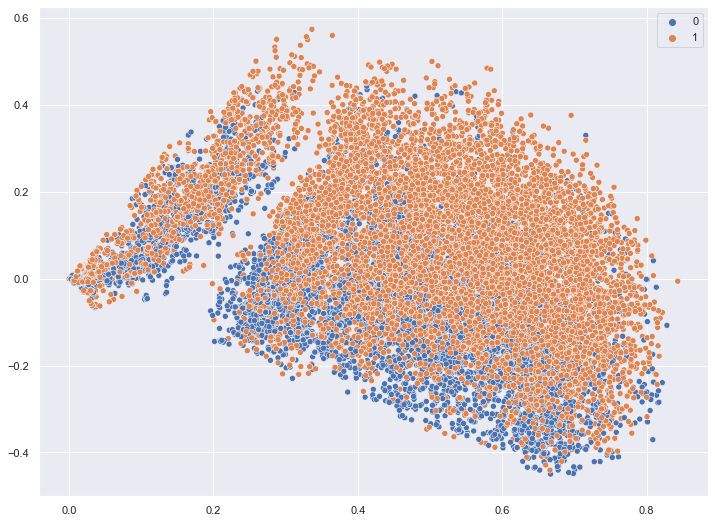

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

dados_tokens = CountVectorizer().fit_transform(Textos)
X = TfidfTransformer(use_idf=False).fit_transform(dados_tokens)

# visualizando classificação
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
sns.set(rc={'figure.figsize':(12,9)})

Xp = TruncatedSVD(n_components=2,random_state=42).fit_transform(X)
_ = sns.scatterplot(x=Xp[:,0],y=Xp[:,1],hue=Tutores)

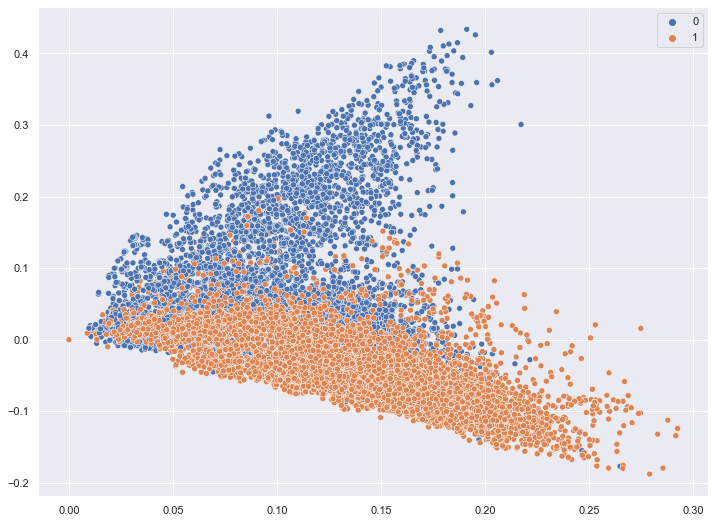

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

dados_tokens = TfidfVectorizer().fit_transform(Textos)
X = TfidfTransformer().fit_transform(dados_tokens)

# visualizando classificação
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
sns.set(rc={'figure.figsize':(12,9)})

Xp = TruncatedSVD(n_components=2,random_state=42).fit_transform(X)
_ = sns.scatterplot(x=Xp[:,0],y=Xp[:,1],hue=Tutores)

In [10]:
X = TruncatedSVD(n_components=100,random_state=42).fit_transform(X)

## Treinamento por Seleção de Modelo (K-Fold)

In [12]:
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, \
                            GradientBoostingClassifier, RandomForestClassifier, \
                            HistGradientBoostingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import PassiveAggressiveClassifier, RidgeClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC, NuSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.model_selection import GridSearchCV

tecnicas = [
    #GaussianProcessClassifier(random_state=42),
    #HistGradientBoostingClassifier(random_state=42),
    DummyClassifier(random_state=42),
    #RadiusNeighborsClassifier(),
    KNeighborsClassifier(),
    SGDClassifier(random_state=42),
    PassiveAggressiveClassifier(random_state=42),
    NuSVC(random_state=42),
    LinearSVC(),
    RidgeClassifier(random_state=42),
    ExtraTreeClassifier(),
    AdaBoostClassifier(random_state=42),
    DecisionTreeClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    ExtraTreesClassifier(random_state=42),
    BaggingClassifier(random_state=42),
    SVC(random_state=42),
    MLPClassifier(random_state=42),
    ]

metricas = ['accuracy','balanced_accuracy','precision','recall','f1']
res = []
for cls in tecnicas:
    grid = GridSearchCV(cls,{},scoring=metricas,n_jobs=-1,cv=5,refit=False)
    grid.fit(X, Tutores)

    dn = {
        'Técnica':cls.__class__.__name__,
        'Tempo':grid.cv_results_['mean_fit_time'][0],
        }
    for mt in metricas:
        dn[mt] = grid.cv_results_['mean_test_' + mt][0]

    print(dn)
    res.append(dn)

{'Técnica': 'DummyClassifier', 'Tempo': 0.019402790069580077, 'accuracy': 0.5329487372026087, 'balanced_accuracy': 0.5, 'precision': 0.5329487372026087, 'recall': 1.0, 'f1': 0.6953249226707856}
{'Técnica': 'KNeighborsClassifier', 'Tempo': 0.022803258895874024, 'accuracy': 0.7537268518395678, 'balanced_accuracy': 0.7491157474305222, 'precision': 0.7397328180359649, 'recall': 0.8191985449366583, 'f1': 0.7715008912026801}
{'Técnica': 'SGDClassifier', 'Tempo': 0.09800314903259277, 'accuracy': 0.7879832371135442, 'balanced_accuracy': 0.7870221529909142, 'precision': 0.7771879254252628, 'recall': 0.8015625, 'f1': 0.7662370106844651}
{'Técnica': 'PassiveAggressiveClassifier', 'Tempo': 0.057701826095581055, 'accuracy': 0.7817972218581218, 'balanced_accuracy': 0.7805968583476369, 'precision': 0.7768277079547388, 'recall': 0.7987740643175842, 'f1': 0.7639195172838911}
{'Técnica': 'NuSVC', 'Tempo': 88.81785960197449, 'accuracy': 0.7882810505831827, 'balanced_accuracy': 0.7886462031028146, 'precis

In [13]:
df = pd.DataFrame(data=res)
df = df.sort_values(by='f1',ascending=False)
df.to_csv('resultados03.csv',index=False,float_format='%.4f')
df

,Técnica,Tempo,accuracy,balanced_accuracy,precision,recall,f1
10,GradientBoostingClassifier,19.151700,0.801839,0.802038,0.791653,0.798885,0.775422
15,MLPClassifier,355.466075,0.792561,0.791513,0.790157,0.807367,0.775236
1,KNeighborsClassifier,0.022803,0.753727,0.749116,0.739733,0.819199,0.771501
11,RandomForestClassifier,15.750163,0.785545,0.785051,0.773943,0.792524,0.768666
5,LinearSVC,0.120108,0.789470,0.788425,0.784523,0.804242,0.767305
12,ExtraTreesClassifier,22.463995,0.784951,0.784258,0.775552,0.794757,0.766319
13,BaggingClassifier,27.820560,0.782869,0.783794,0.791364,0.769645,0.766250
2,SGDClassifier,0.098003,0.787983,0.787022,0.777188,0.801562,0.766237
8,AdaBoostClassifier,5.280910,0.773826,0.772217,0.755795,0.796543,0.765363
3,PassiveAggressiveClassifier,0.057702,0.781797,0.780597,0.776828,0.798774,0.763920


In [49]:
rsp = pd.read_csv('resultados00.csv')
rsp = rsp.sort_values(by='Tempo')
rsp

,Técnica,Tempo,accuracy,precision,recall,f1
16,GaussianProcessClassifier,0.0443,NaN,NaN,NaN,NaN
15,HistGradientBoostingClassifier,0.0445,NaN,NaN,NaN,NaN
14,DummyClassifier,0.0535,0.7599,0.0000,0.0000,0.0000
17,RadiusNeighborsClassifier,0.0689,NaN,NaN,NaN,NaN
11,KNeighborsClassifier,0.0713,0.8204,0.6462,0.5869,0.5785
7,SGDClassifier,0.1969,0.8546,0.7855,0.5828,0.6123
4,PassiveAggressiveClassifier,0.2018,0.8355,0.6633,0.6073,0.6189
18,NuSVC,0.2734,NaN,NaN,NaN,NaN
3,LinearSVC,0.4295,0.8516,0.7389,0.5966,0.6196
8,RidgeClassifier,0.4733,0.8545,0.7925,0.5783,0.6098
